In [1]:
import sys
!{sys.executable} -m pip install ultralytics opencv-python matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import ultralytics
import os
import shutil
import random
import yaml
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO

ultralytics.checks()

Ultralytics 8.3.159 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7816MiB)
Setup complete ✅ (12 CPUs, 30.9 GB RAM, 102.4/227.8 GB disk)


In [3]:
# Import class names from existing YAML file
def load_class_names_from_yaml(yaml_path):
    """Load class names from existing data.yaml file."""
    if os.path.exists(yaml_path):
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        class_names = data.get('names', [])
        if isinstance(class_names, dict):
            # If names is a dictionary (class_id: class_name), convert to list
            class_names = [class_names[i] for i in sorted(class_names.keys())]
        elif isinstance(class_names, list):
            # If names is already a list, use as is
            pass
        else:
            raise ValueError("Class names in YAML should be either a list or dictionary")

        # Validate class names
        if not class_names:
            raise ValueError("No class names found in YAML file")

        # Check for valid class names (no empty strings)
        class_names = [str(name).strip() for name in class_names if str(name).strip()]

        print(f"Loaded {len(class_names)} class names from {yaml_path}")
        print(f"Classes: {class_names}")
        return class_names
    else:
        raise FileNotFoundError(f"YAML file not found: {yaml_path}")

def validate_yaml_structure(yaml_path):
    """Validate the structure of a YAML file for YOLOv8 compatibility."""
    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        required_keys = ['names']
        optional_keys = ['path', 'train', 'val', 'test', 'nc']

        missing_keys = [key for key in required_keys if key not in data]
        if missing_keys:
            print(f"Warning: Missing required keys in YAML: {missing_keys}")

        present_keys = [key for key in optional_keys if key in data]
        print(f"Present optional keys: {present_keys}")

        # Validate nc matches number of names
        if 'nc' in data and 'names' in data:
            names = data['names']
            if isinstance(names, list):
                expected_nc = len(names)
            elif isinstance(names, dict):
                expected_nc = len(names)
            else:
                expected_nc = 0

            if data['nc'] != expected_nc:
                print(f"Warning: 'nc' ({data['nc']}) doesn't match number of class names ({expected_nc})")

        return True
    except Exception as e:
        print(f"Error validating YAML: {e}")
        return False

# Dataset configuration
DATASET_PATH = "data/YOLO-Bulk"  # dataset path
OUTPUT_PATH = "yolo_dataset_split"
YAML_CONFIG_PATH = "data/YOLO-Bulk/data.yaml"  # Path to data.yaml 

# Load class names from YAML file
try:
    # First validate the YAML structure
    if os.path.exists(YAML_CONFIG_PATH):
        print("Validating YAML file structure...")
        validate_yaml_structure(YAML_CONFIG_PATH)

    CLASS_NAMES = load_class_names_from_yaml(YAML_CONFIG_PATH)
except FileNotFoundError:
    print(f"Warning: {YAML_CONFIG_PATH} not found. Using default class names.")
    CLASS_NAMES = ["class1", "class2", "class3"]  # Fallback default classes
except Exception as e:
    print(f"Error loading YAML: {e}")
    print("Using default class names.")
    CLASS_NAMES = ["class1", "class2", "class3"]  # Fallback default classes

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Training configuration
MODEL_SIZE = "yolov8n.pt"  # Options: yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
EPOCHS = 100
IMAGE_SIZE = 640
BATCH_SIZE = 16

print(f"Train: {TRAIN_RATIO*100}%, Val: {VAL_RATIO*100}%, Test: {TEST_RATIO*100}%")
print(f"Number of classes: {len(CLASS_NAMES)}")

Validating YAML file structure...
Present optional keys: ['nc']
Loaded 26 class names from data/YOLO-Bulk/data.yaml
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Train: 70.0%, Val: 15.0%, Test: 15.0%
Number of classes: 26


In [4]:
def inspect_yaml_file(yaml_path):
    """Inspect and display the contents of a YAML configuration file."""
    if not os.path.exists(yaml_path):
        print(f"YAML file not found: {yaml_path}")
        return None

    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    print("YAML File Contents:")
    print("=" * 50)
    for key, value in data.items():
        print(f"{key}: {value}")

    return data

def create_example_yaml_files():
    """Create example YAML files for different use cases."""
    # Example 1: Simple 3-class dataset
    example1 = {
        'path': '/path/to/dataset',
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': 3,
        'names': ['person', 'car', 'bicycle']
    }

    with open('example_data_list.yaml', 'w') as f:
        yaml.dump(example1, f, default_flow_style=False)

    # Example 2: Dictionary format
    example2 = {
        'path': '/path/to/dataset',
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': 3,
        'names': {0: 'person', 1: 'car', 2: 'bicycle'} 
    }

    with open('example_data_dict.yaml', 'w') as f:
        yaml.dump(example2, f, default_flow_style=False)

    print("Created example YAML files:")
    print("- example_data_list.yaml (list format)")
    print("- example_data_dict.yaml (dictionary format)")

# Inspect existing YAML file
print("Checking data.yaml...")
if os.path.exists(YAML_CONFIG_PATH):
    yaml_data = inspect_yaml_file(YAML_CONFIG_PATH)
    print("\nValidating YAML structure...")
    validate_yaml_structure(YAML_CONFIG_PATH)
else:
    print(f"YAML file '{YAML_CONFIG_PATH}' not found.")
    print("Expected location: /data/YOLO-Bulk/data.yaml")
    create_sample_yaml()

Checking data.yaml...
YAML File Contents:
nc: 26
names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
roboflow: {'workspace': 'david-lee-d0rhs', 'project': 'american-sign-language-letters', 'version': 1, 'license': 'Public Domain', 'url': 'https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1'}

Validating YAML structure...
Present optional keys: ['nc']


In [5]:
def analyze_dataset(dataset_path):
    """Analyze the original dataset structure and content."""
    print("Dataset Analysis:")
    print("=" * 50)

    images_path = os.path.join(dataset_path, "images")
    labels_path = os.path.join(dataset_path, "labels")

    if not os.path.exists(images_path) or not os.path.exists(labels_path):
        print("Error: Expected 'images' and 'labels' folders in dataset path")
        return False

    # Count files
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    label_files = [f for f in os.listdir(labels_path) if f.lower().endswith('.txt')]

    print(f"Images found: {len(image_files)}")
    print(f"Labels found: {len(label_files)}")

    # Check for matching files
    image_names = {os.path.splitext(f)[0] for f in image_files}
    label_names = {os.path.splitext(f)[0] for f in label_files}

    matched = len(image_names.intersection(label_names))
    unmatched_images = len(image_names - label_names)
    unmatched_labels = len(label_names - image_names)

    print(f"Matched image-label pairs: {matched}")
    print(f"Images without labels: {unmatched_images}")
    print(f"Labels without images: {unmatched_labels}")

    return True

# Analyze the dataset
analyze_dataset(DATASET_PATH)

Dataset Analysis:
Images found: 1728
Labels found: 1728
Matched image-label pairs: 1728
Images without labels: 0
Labels without images: 0


True

In [6]:
def create_directory_structure(output_path):
    """Create the directory structure for train/val/test splits."""
    splits = ['train', 'val', 'test']

    for split in splits:
        os.makedirs(os.path.join(output_path, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_path, split, 'labels'), exist_ok=True)

    print(f"Created directory structure at: {output_path}")

def get_matched_files(dataset_path):
    """Get list of files that have both image and label."""
    images_path = os.path.join(dataset_path, "images")
    labels_path = os.path.join(dataset_path, "labels")

    if not os.path.exists(images_path) or not os.path.exists(labels_path):
        raise FileNotFoundError(f"Images or labels directory not found in {dataset_path}")

    # Get all image files with multiple extensions
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')
    image_files = []
    for ext in image_extensions:
        image_files.extend([f for f in os.listdir(images_path) if f.lower().endswith(ext)])

    print(f"Found {len(image_files)} image files")

    # Filter to only those with corresponding labels
    matched_files = []
    missing_labels = []

    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        label_file = base_name + '.txt'

        img_path = os.path.join(images_path, img_file)
        label_path = os.path.join(labels_path, label_file)

        if os.path.exists(label_path):
            matched_files.append((img_path, label_path, base_name, img_file))
        else:
            missing_labels.append(img_file)

    if missing_labels:
        print(f"Warning: {len(missing_labels)} images don't have corresponding labels")
        if len(missing_labels) <= 10:
            print(f"Missing labels for: {missing_labels}")
        else:
            print(f"First 10 missing labels: {missing_labels[:10]}")

    print(f"Matched image-label pairs: {len(matched_files)}")
    return matched_files

def split_dataset(matched_files, train_ratio, val_ratio, test_ratio):
    """Split the dataset into train/val/test sets."""
    random.shuffle(matched_files)

    total_files = len(matched_files)
    train_count = int(total_files * train_ratio)
    val_count = int(total_files * val_ratio)

    train_files = matched_files[:train_count]
    val_files = matched_files[train_count:train_count + val_count]
    test_files = matched_files[train_count + val_count:]

    print(f"Split summary:")
    print(f"Train: {len(train_files)} files ({len(train_files)/total_files*100:.1f}%)")
    print(f"Val: {len(val_files)} files ({len(val_files)/total_files*100:.1f}%)")
    print(f"Test: {len(test_files)} files ({len(test_files)/total_files*100:.1f}%)")

    return train_files, val_files, test_files

def copy_files(file_list, output_path, split_name):
    """Copy files to the appropriate split directory."""
    for img_path, label_path, base_name, img_filename in file_list:
        # Copy image (preserve original extension)
        img_ext = os.path.splitext(img_filename)[1]
        new_img_path = os.path.join(output_path, split_name, 'images', base_name + img_ext)
        shutil.copy2(img_path, new_img_path)

        # Copy label
        new_label_path = os.path.join(output_path, split_name, 'labels', base_name + '.txt')
        shutil.copy2(label_path, new_label_path)

    print(f"Copied {len(file_list)} files to {split_name} split")

In [7]:
create_directory_structure(OUTPUT_PATH)

matched_files = get_matched_files(DATASET_PATH)

if len(matched_files) == 0:
    print("Error: No matched image-label pairs found!")
    print("Please check that:")
    print("1. Images are in /data/YOLO-Bulk/images/")
    print("2. Labels are in /data/YOLO-Bulk/labels/")
    print("3. Image and label files have matching names (except extensions)")
else:
    print(f"Ready to split {len(matched_files)} matched image-label pairs")

    # Split the dataset
    train_files, val_files, test_files = split_dataset(
        matched_files, TRAIN_RATIO, VAL_RATIO, TEST_RATIO
    )

    # Copy files to respective directories
    copy_files(train_files, OUTPUT_PATH, 'train')
    copy_files(val_files, OUTPUT_PATH, 'val')
    copy_files(test_files, OUTPUT_PATH, 'test')

    print("\n" + "="*50)
    print("DATASET SPLIT COMPLETED SUCCESSFULLY!")
    print("="*50)
    print(f"Original dataset: {DATASET_PATH}")
    print(f"Split dataset: {OUTPUT_PATH}")
    print(f"Total files processed: {len(matched_files)}")

Created directory structure at: yolo_dataset_split
Found 1728 image files
Matched image-label pairs: 1728
Ready to split 1728 matched image-label pairs
Split summary:
Train: 1209 files (70.0%)
Val: 259 files (15.0%)
Test: 260 files (15.0%)
Copied 1209 files to train split
Copied 259 files to val split
Copied 260 files to test split

DATASET SPLIT COMPLETED SUCCESSFULLY!
Original dataset: data/YOLO-Bulk
Split dataset: yolo_dataset_split
Total files processed: 1728


In [8]:
def create_yaml_config(output_path, class_names, base_yaml_path=None):
    """Create YAML configuration file for YOLOv8."""
    # Start with base configuration if provided
    config = {}
    if base_yaml_path and os.path.exists(base_yaml_path):
        with open(base_yaml_path, 'r') as f:
            config = yaml.safe_load(f) or {}
        print(f"Using base configuration from: {base_yaml_path}")

    # Update with new paths and class information
    config.update({
        'path': os.path.abspath(output_path),
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': len(class_names),
        'names': class_names
    })

    yaml_path = os.path.join(output_path, 'dataset.yaml')

    with open(yaml_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    print(f"Created YAML config at: {yaml_path}")
    return yaml_path

# Create YAML configuration, optionally using existing YAML as base
yaml_config_path = create_yaml_config(OUTPUT_PATH, CLASS_NAMES, YAML_CONFIG_PATH if os.path.exists(YAML_CONFIG_PATH) else None)

# Display the config
with open(yaml_config_path, 'r') as f:
    print("\nDataset configuration:")
    print(f.read())

Using base configuration from: data/YOLO-Bulk/data.yaml
Created YAML config at: yolo_dataset_split/dataset.yaml

Dataset configuration:
names:
- A
- B
- C
- D
- E
- F
- G
- H
- I
- J
- K
- L
- M
- N
- O
- P
- Q
- R
- S
- T
- U
- V
- W
- X
- Y
- Z
nc: 26
path: /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split
roboflow:
  license: Public Domain
  project: american-sign-language-letters
  url: https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1
  version: 1
  workspace: david-lee-d0rhs
test: test/images
train: train/images
val: val/images




Sample images from train set:


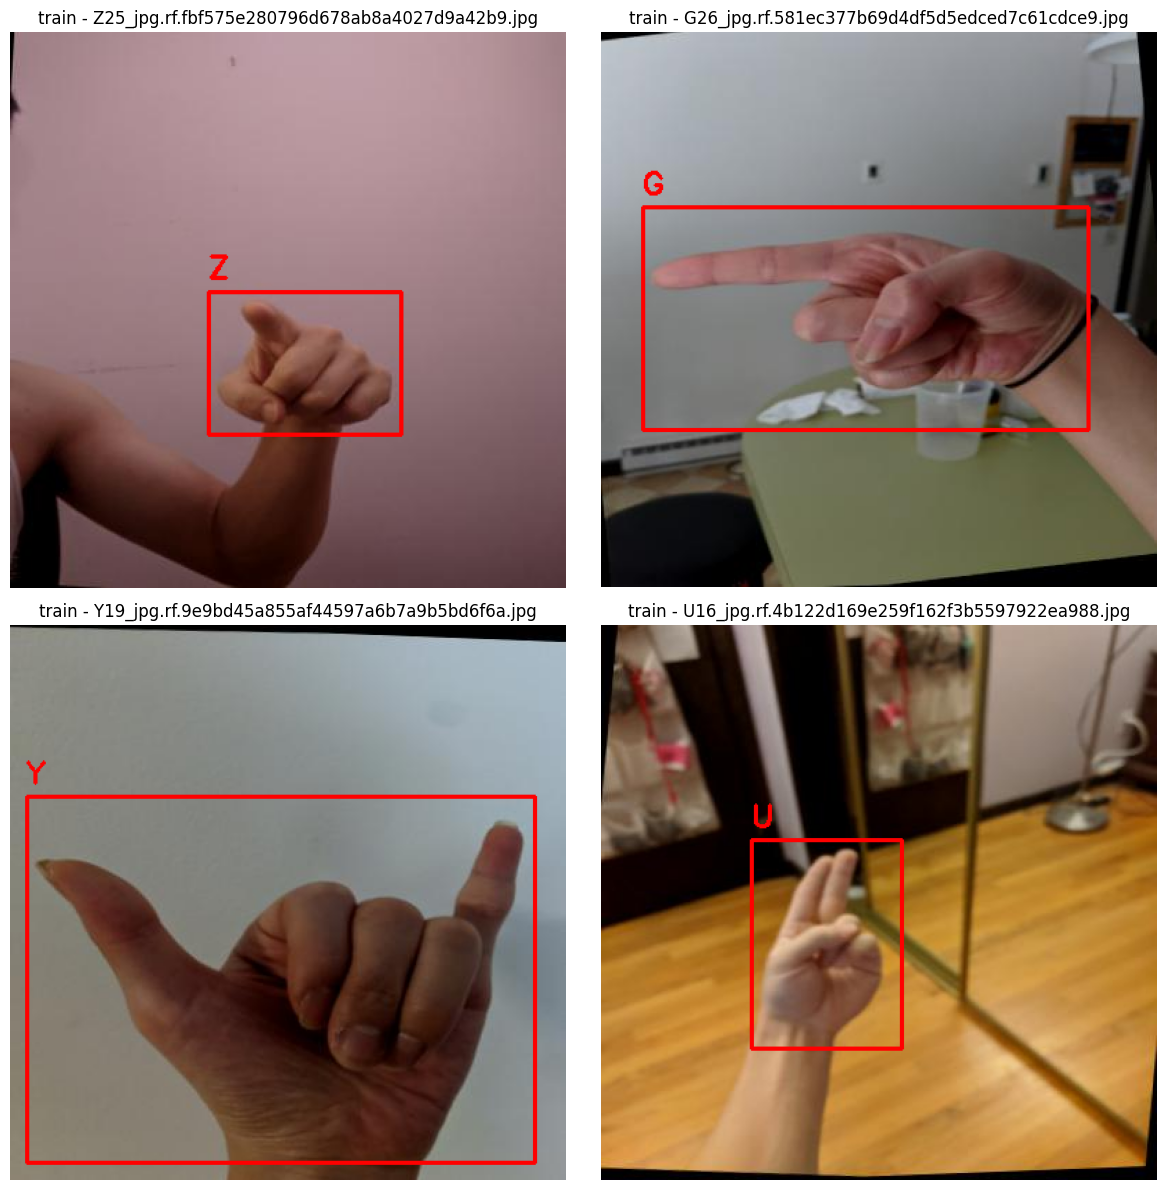


Sample images from val set:


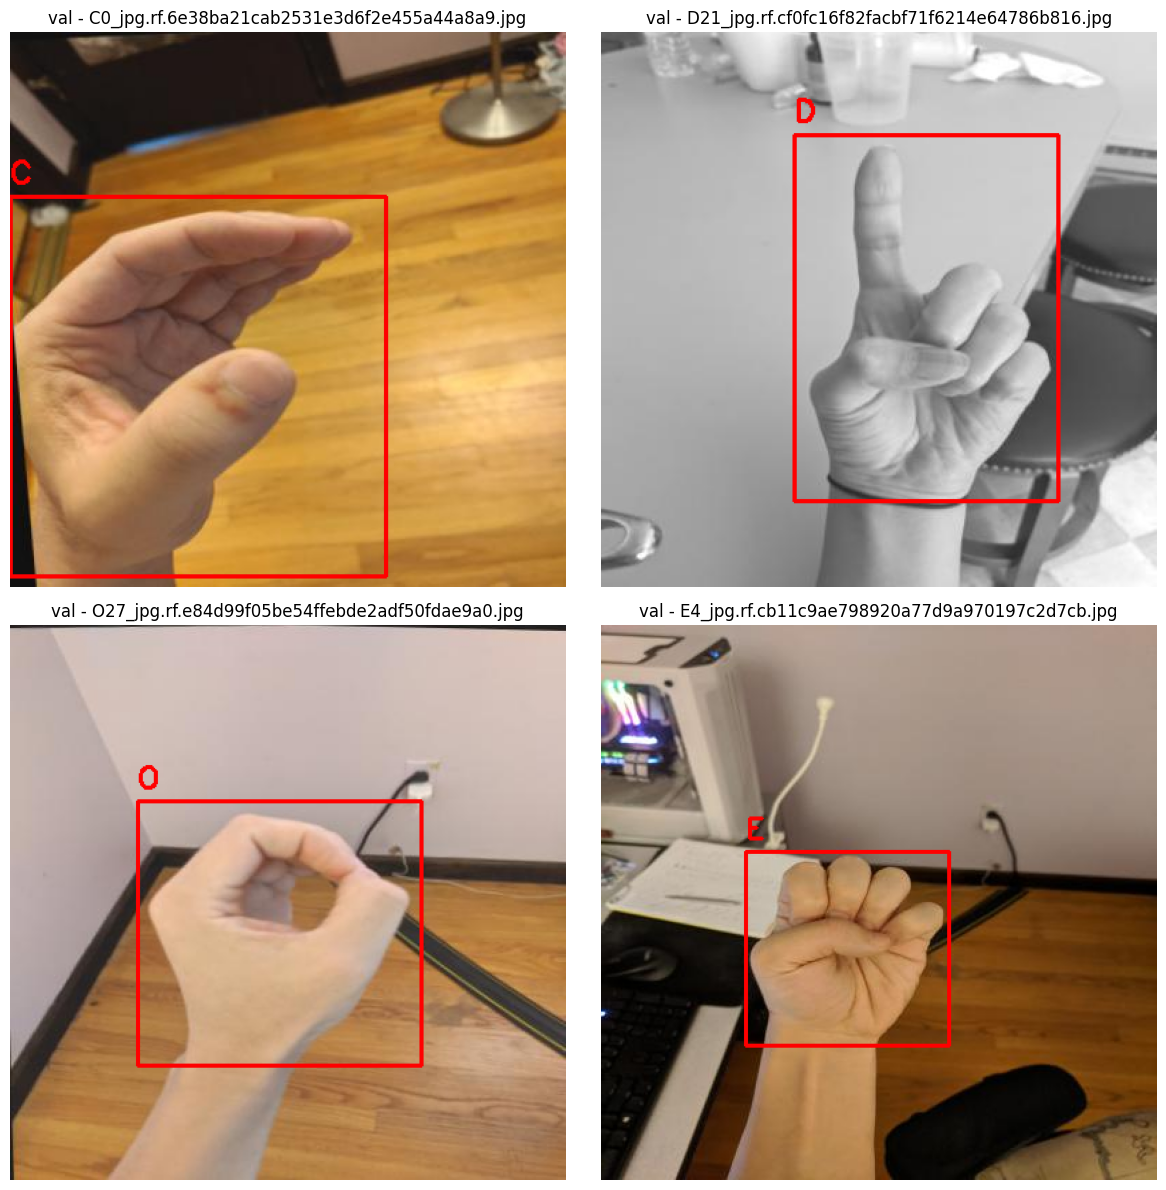


Sample images from test set:


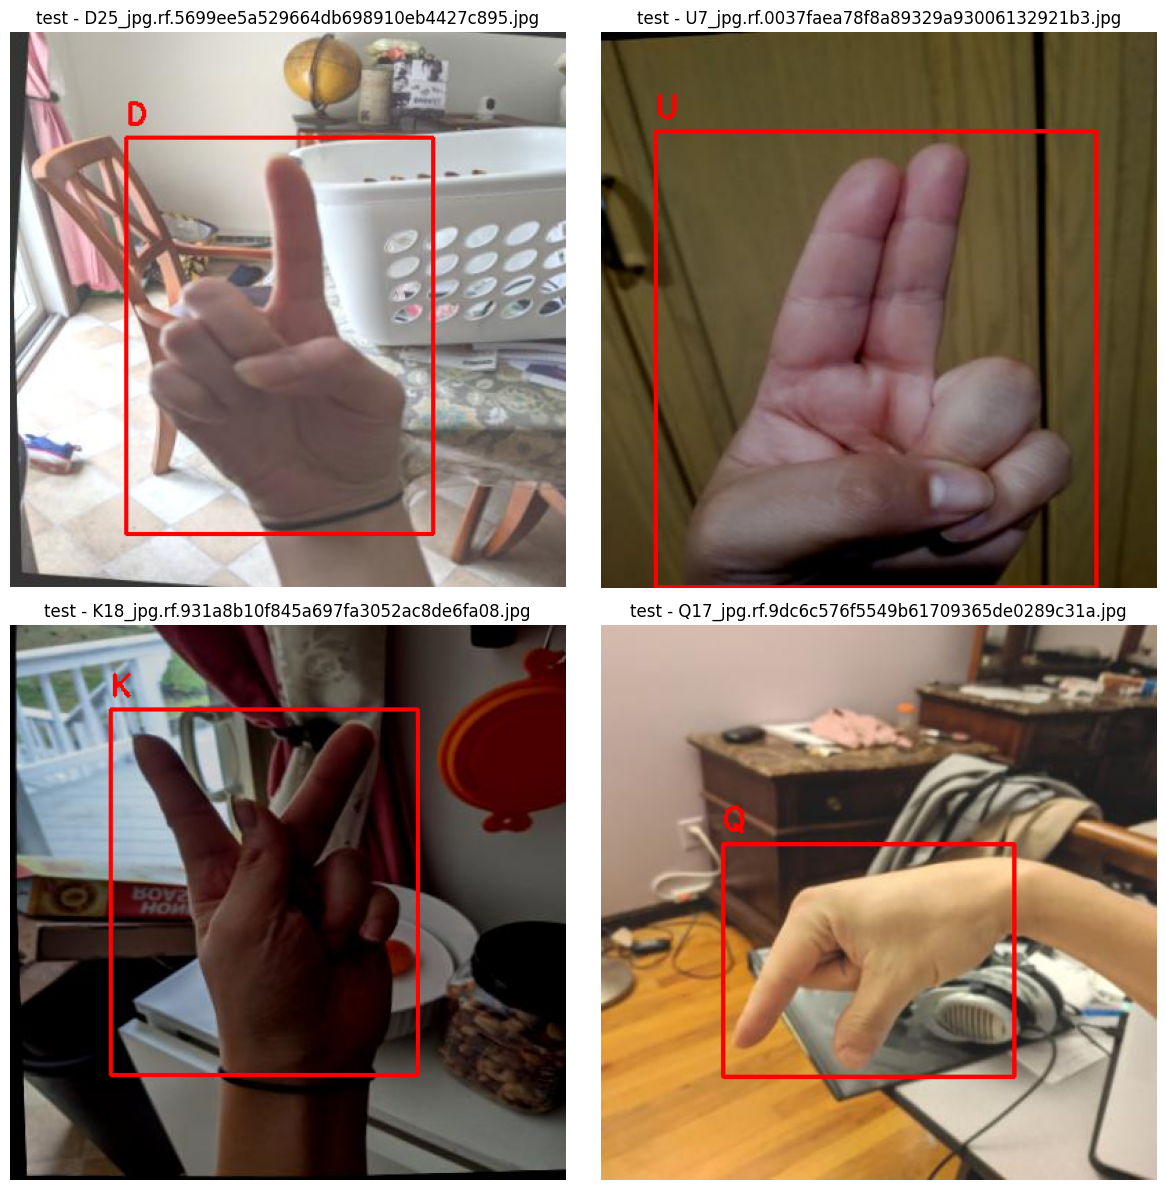

In [9]:
def visualize_samples(output_path, split='train', num_samples=4):
    """Visualize sample images with their annotations."""
    images_dir = os.path.join(output_path, split, 'images')
    labels_dir = os.path.join(output_path, split, 'labels')

    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.ravel()

    for idx, img_file in enumerate(sample_files):
        if idx >= 4:
            break

        # Load image
        img_path = os.path.join(images_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        # Load annotations
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(labels_dir, base_name + '.txt')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)

                    # Convert to pixel coordinates
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h

                    # Draw bounding box
                    x1 = int(x_center - width/2)
                    y1 = int(y_center - height/2)
                    x2 = int(x_center + width/2)
                    y2 = int(y_center + height/2)

                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

                    # Add class label
                    if int(class_id) < len(CLASS_NAMES):
                        label = CLASS_NAMES[int(class_id)]
                        cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

        axes[idx].imshow(image)
        axes[idx].set_title(f'{split} - {img_file}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples from each split
for split in ['train', 'val', 'test']:
    print(f"\nSample images from {split} set:")
    visualize_samples(OUTPUT_PATH, split)

In [10]:
def train_yolo_model(yaml_config_path, model_size, epochs, image_size, batch_size):
    """Train YOLOv8 model."""
    print(f"Starting training with {model_size}")
    print(f"Configuration: epochs={epochs}, image_size={image_size}, batch_size={batch_size}")

    # Load model
    model = YOLO(model_size)

    # Train the model
    results = model.train(
        data=yaml_config_path,
        epochs=epochs,
        imgsz=image_size,
        batch=batch_size,
        save=True,
        project='ASL-fingerspelling',
        name='asl-model',
        exist_ok=True, # overwrite
        patience=20,
        save_period=10
    )

    return model, results

# Start training
print("Initializing model training...")
model, training_results = train_yolo_model(
    yaml_config_path, MODEL_SIZE, EPOCHS, IMAGE_SIZE, BATCH_SIZE
)

print("Training completed!")

Initializing model training...
Starting training with yolov8n.pt
Configuration: epochs=100, image_size=640, batch_size=16
New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7816MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset_split/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=

train: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/train/labels... 1562 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1562/1562 [00:00<00:00, 6261.29it/s]

train: New cache created: /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/train/labels.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 361.8±147.7 MB/s, size: 8.4 KB)


val: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/val/labels... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<00:00, 3604.93it/s]

val: New cache created: /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/val/labels.cache


Plotting labels to ASL-fingerspelling/asl-model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000333, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ASL-fingerspelling/asl-model
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.99G      1.028      4.285      1.453         15        640: 100%|██████████| 98/98 [00:09<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.07it/s]

                   all        474        474     0.0296       0.88      0.099     0.0799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      2/100      2.47G     0.9052      3.458      1.356         27        640: 100%|██████████| 98/98 [00:08<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.99it/s]

                   all        474        474      0.381      0.441      0.333      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      3/100      2.47G     0.8992      2.967      1.344         29        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.00it/s]

                   all        474        474      0.411      0.607      0.549      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      4/100      2.47G     0.8967      2.639      1.344         21        640: 100%|██████████| 98/98 [00:08<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.97it/s]

                   all        474        474      0.574      0.655      0.692      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      5/100      2.48G     0.8509      2.386       1.29         19        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.00it/s]

                   all        474        474      0.676      0.792      0.821      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      6/100      2.48G     0.8537      2.195      1.277         27        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.03it/s]

                   all        474        474      0.718      0.853      0.901      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      7/100      2.48G     0.8133      1.972      1.252         20        640: 100%|██████████| 98/98 [00:08<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.10it/s]

                   all        474        474      0.799      0.824      0.894      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.48G     0.7938      1.864      1.243         22        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.08it/s]

                   all        474        474      0.799        0.8       0.91      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      9/100      2.48G     0.7883      1.698       1.21         23        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.10it/s]

                   all        474        474      0.911      0.923      0.968      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     10/100      2.48G     0.7559      1.639      1.196         25        640: 100%|██████████| 98/98 [00:08<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.08it/s]

                   all        474        474      0.908      0.904      0.957      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     11/100      2.48G     0.7582      1.545      1.193         21        640: 100%|██████████| 98/98 [00:08<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.11it/s]

                   all        474        474      0.868      0.947      0.967      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     12/100      2.49G     0.7606      1.492      1.198         26        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.06it/s]

                   all        474        474      0.904      0.923      0.979      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     13/100      2.49G      0.747      1.453       1.19         20        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.08it/s]

                   all        474        474      0.928      0.936      0.977      0.855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     14/100      2.49G     0.7282      1.344      1.172         25        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.07it/s]

                   all        474        474      0.929      0.948      0.983      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     15/100       2.5G     0.7247      1.351      1.179         20        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.11it/s]

                   all        474        474      0.952      0.941      0.987      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     16/100       2.5G     0.7257      1.304      1.163         25        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.14it/s]

                   all        474        474      0.951      0.943      0.985      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     17/100      2.51G     0.7316      1.295      1.177         11        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.11it/s]

                   all        474        474      0.965      0.966      0.992      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     18/100      2.51G     0.7185      1.216      1.163         21        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.14it/s]

                   all        474        474      0.979       0.96      0.991      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     19/100      2.52G     0.7012      1.166      1.151         18        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.14it/s]

                   all        474        474       0.97      0.956      0.992      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     20/100      2.52G     0.7014      1.149      1.151         16        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.13it/s]

                   all        474        474      0.973       0.97      0.991       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     21/100      2.53G     0.6959      1.091      1.144         21        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.16it/s]

                   all        474        474      0.984      0.975      0.993       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     22/100      2.53G     0.7055      1.095      1.153         19        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.15it/s]

                   all        474        474      0.974      0.981      0.992      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     23/100      2.54G     0.6797      1.051      1.136         18        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.17it/s]

                   all        474        474      0.966      0.974      0.993      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     24/100      2.54G     0.6845      1.058      1.137         29        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.18it/s]

                   all        474        474       0.97      0.983      0.993      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     25/100      2.55G     0.6878      1.029      1.141         21        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.22it/s]

                   all        474        474      0.973      0.991      0.994      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     26/100      2.55G     0.6879       1.03      1.137         23        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.18it/s]

                   all        474        474      0.974      0.988      0.995      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     27/100      2.55G     0.6667      0.975      1.129         19        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.18it/s]

                   all        474        474      0.982      0.982      0.995      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     28/100      2.55G     0.6786     0.9765      1.129         24        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.21it/s]

                   all        474        474      0.981      0.986      0.994      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     29/100      2.56G      0.671     0.9476      1.126         27        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.20it/s]

                   all        474        474      0.979      0.981      0.994      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     30/100      2.57G     0.6684     0.9398      1.126         18        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.21it/s]

                   all        474        474      0.983      0.986      0.995      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     31/100      2.57G     0.6508     0.9101      1.113         24        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.18it/s]

                   all        474        474      0.981      0.993      0.995      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     32/100      2.57G     0.6532     0.8941      1.112         26        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

                   all        474        474      0.986       0.99      0.994       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.57G     0.6648     0.9007      1.121         22        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.18it/s]

                   all        474        474      0.987      0.992      0.995      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     34/100      2.57G     0.6507     0.8885      1.108         25        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.20it/s]

                   all        474        474      0.982      0.995      0.994      0.901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     35/100      2.57G     0.6486     0.8538       1.11         28        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.25it/s]

                   all        474        474      0.985      0.995      0.994      0.894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     36/100      2.57G      0.639     0.8635      1.111         15        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

                   all        474        474       0.98      0.992      0.993      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     37/100      2.57G     0.6439     0.8339      1.109         19        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.23it/s]

                   all        474        474       0.98      0.996      0.995      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     38/100      2.57G     0.6201     0.8111      1.098         20        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.23it/s]

                   all        474        474      0.986      0.994      0.995      0.898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     39/100      2.57G     0.6332     0.8227      1.102         23        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.23it/s]

                   all        474        474      0.985      0.996      0.995      0.904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     40/100      2.57G     0.6212     0.7559      1.095         21        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.20it/s]

                   all        474        474       0.99      0.991      0.995      0.905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     41/100      2.57G      0.628     0.7869      1.098         22        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.23it/s]

                   all        474        474      0.988      0.991      0.995      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     42/100      2.57G     0.6218     0.7722      1.088         16        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

                   all        474        474      0.989      0.998      0.995      0.901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     43/100      2.57G     0.6411     0.7885      1.108         25        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

                   all        474        474       0.99      0.989      0.995      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     44/100      2.57G      0.625     0.7722      1.096         17        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

                   all        474        474      0.993      0.997      0.995      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     45/100      2.57G     0.6167     0.7527      1.088         18        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

                   all        474        474      0.992      0.999      0.995      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     46/100      2.57G     0.6092     0.7424      1.078         20        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

                   all        474        474      0.989      0.996      0.995      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     47/100      2.57G     0.6016     0.7298      1.085         21        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

                   all        474        474      0.993      0.994      0.995      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     48/100      2.57G     0.6058     0.7257      1.089         20        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

                   all        474        474      0.992      0.994      0.995      0.907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     49/100      2.57G     0.5999     0.7108      1.083         19        640: 100%|██████████| 98/98 [00:08<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

                   all        474        474      0.991      0.997      0.995      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     50/100      2.57G     0.6062     0.6977      1.081         18        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.25it/s]

                   all        474        474       0.99      0.997      0.995      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     51/100      2.57G     0.5946     0.6928      1.076         25        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

                   all        474        474      0.989      0.992      0.995      0.907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     52/100      2.57G     0.5934     0.6919       1.07         18        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.25it/s]

                   all        474        474      0.994      0.993      0.995      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     53/100      2.57G      0.598     0.6873      1.077         19        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

                   all        474        474      0.988      0.994      0.994      0.904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     54/100      2.57G     0.5961     0.6774       1.08         24        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.23it/s]

                   all        474        474      0.991      0.995      0.995      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     55/100      2.57G     0.5681     0.6447      1.057         17        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

                   all        474        474      0.991      0.994      0.995      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     56/100      2.57G     0.5874     0.6489      1.077         19        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

                   all        474        474      0.984      0.992      0.994      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     57/100      2.57G     0.5859     0.6423      1.062         25        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.29it/s]

                   all        474        474      0.989      0.995      0.994      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     58/100      2.57G     0.5746     0.6515       1.07         22        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.27it/s]

                   all        474        474      0.991      0.997      0.995      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     59/100      2.57G     0.5593     0.6111      1.051         26        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.30it/s]

                   all        474        474      0.994      0.997      0.995       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     60/100      2.57G     0.5609     0.6325      1.054         23        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.22it/s]

                   all        474        474      0.991      0.997      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.57G     0.5782     0.6299      1.064         23        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.27it/s]

                   all        474        474      0.991      0.996      0.995       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     62/100      2.57G     0.5632     0.6184      1.061         22        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

                   all        474        474       0.99      0.997      0.995      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     63/100      2.57G     0.5737     0.6145      1.069         20        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

                   all        474        474      0.994      0.998      0.995      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     64/100      2.57G      0.567     0.5995      1.057         22        640: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

                   all        474        474      0.992      0.993      0.995      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     65/100      2.57G     0.5623     0.6049      1.053         30        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.28it/s]

                   all        474        474       0.99      0.994      0.995      0.917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     66/100      2.57G     0.5559        0.6      1.054         25        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.27it/s]

                   all        474        474      0.991      0.999      0.995      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     67/100      2.57G     0.5672     0.5963       1.06         23        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.25it/s]

                   all        474        474      0.993      0.997      0.995      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     68/100      2.57G     0.5403     0.5648      1.046         27        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.28it/s]

                   all        474        474      0.992      0.999      0.995      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     69/100      2.57G       0.56     0.5905      1.054         19        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

                   all        474        474      0.992      0.997      0.995      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     70/100      2.57G     0.5462     0.5852      1.048         26        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.28it/s]

                   all        474        474      0.994      0.998      0.995      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     71/100      2.57G     0.5443     0.5634      1.048         26        640: 100%|██████████| 98/98 [00:08<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.29it/s]

                   all        474        474      0.991      0.997      0.995      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     72/100      2.57G     0.5398     0.5635      1.039         23        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.30it/s]

                   all        474        474      0.993      0.995      0.995      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     73/100      2.57G     0.5351     0.5783      1.046         23        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.31it/s]

                   all        474        474       0.99      0.997      0.995       0.93

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     74/100      2.57G     0.5424      0.543      1.038         19        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.30it/s]

                   all        474        474      0.994      0.998      0.995      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     75/100      2.57G      0.529     0.5538      1.038         25        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.29it/s]

                   all        474        474      0.995      0.995      0.995      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     76/100      2.57G      0.544     0.5509      1.054         24        640: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.29it/s]

                   all        474        474      0.993      0.998      0.995      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     77/100      2.57G     0.5383     0.5401      1.048         21        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.31it/s]

                   all        474        474      0.994      0.998      0.995      0.933

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     78/100      2.57G     0.5243     0.5446      1.035         18        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.30it/s]

                   all        474        474      0.993      0.998      0.995      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     79/100      2.57G     0.5137     0.5337      1.036         22        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.30it/s]

                   all        474        474      0.995      0.999      0.995      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     80/100      2.57G     0.5169     0.5349      1.034         28        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.30it/s]

                   all        474        474      0.994      0.999      0.995      0.932

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     81/100      2.57G     0.5205     0.5312      1.031         28        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.31it/s]

                   all        474        474      0.995      0.999      0.995      0.934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     82/100      2.57G     0.5237     0.5356       1.03         20        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.29it/s]

                   all        474        474      0.995          1      0.995      0.933

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     83/100      2.57G     0.5198     0.5329      1.031         18        640: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.31it/s]

                   all        474        474      0.994      0.999      0.995      0.932

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     84/100      2.57G     0.5169     0.5246      1.035         16        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.23it/s]

                   all        474        474      0.993      0.999      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.57G     0.5193     0.5247      1.035         20        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

                   all        474        474      0.993      0.998      0.995      0.934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     86/100      2.57G     0.5157     0.5182      1.032         26        640: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.29it/s]

                   all        474        474      0.993      0.998      0.995      0.933

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     87/100      2.57G     0.5097     0.5193      1.029         20        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.28it/s]

                   all        474        474      0.994      0.999      0.995      0.934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     88/100      2.57G     0.5125     0.5272      1.032         26        640: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.29it/s]

                   all        474        474      0.994      0.999      0.995      0.941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     89/100      2.57G     0.4996     0.4961      1.019         24        640: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

                   all        474        474      0.995          1      0.995      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     90/100      2.57G     0.4988     0.5031      1.018         32        640: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.23it/s]

                   all        474        474      0.995          1      0.995      0.933
Closing dataloader mosaic



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.57G     0.3652     0.3159     0.9422         10        640: 100%|██████████| 98/98 [00:08<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.22it/s]

                   all        474        474      0.994          1      0.995      0.936

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     92/100      2.57G     0.3581     0.3023     0.9465         10        640: 100%|██████████| 98/98 [00:08<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.27it/s]

                   all        474        474      0.995          1      0.995      0.937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     93/100      2.57G     0.3535     0.2941     0.9354         10        640: 100%|██████████| 98/98 [00:08<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.28it/s]

                   all        474        474      0.996      0.999      0.995      0.937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     94/100      2.57G     0.3521     0.2913     0.9471         10        640: 100%|██████████| 98/98 [00:08<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.27it/s]

                   all        474        474      0.995      0.999      0.995      0.941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     95/100      2.57G     0.3433     0.2859     0.9251         10        640: 100%|██████████| 98/98 [00:08<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

                   all        474        474      0.996          1      0.995       0.94

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     96/100      2.57G     0.3347     0.2791     0.9221         10        640: 100%|██████████| 98/98 [00:08<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.25it/s]

                   all        474        474      0.996      0.999      0.995      0.942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     97/100      2.57G     0.3395     0.2788     0.9268         10        640: 100%|██████████| 98/98 [00:08<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.28it/s]

                   all        474        474      0.996          1      0.995      0.944

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     98/100      2.57G     0.3336     0.2772     0.9206         10        640: 100%|██████████| 98/98 [00:08<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.28it/s]

                   all        474        474      0.996      0.999      0.995      0.944

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     99/100      2.57G     0.3299     0.2756     0.9213         10        640: 100%|██████████| 98/98 [00:08<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

                   all        474        474      0.996          1      0.995      0.943

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    100/100      2.57G     0.3305     0.2729     0.9225         10        640: 100%|██████████| 98/98 [00:08<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

                   all        474        474      0.996          1      0.995      0.944

100 epochs completed in 0.286 hours.


Optimizer stripped from ASL-fingerspelling/asl-model/weights/last.pt, 6.3MB
Optimizer stripped from ASL-fingerspelling/asl-model/weights/best.pt, 6.3MB

Validating ASL-fingerspelling/asl-model/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7816MiB)
Model summary (fused): 72 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.00it/s]


                   all        474        474      0.996      0.999      0.995      0.944
                     A         22         22      0.998          1      0.995      0.928
                     B         16         16      0.995          1      0.995       0.95
                     C         21         21      0.998          1      0.995      0.956
                     D         19         19      0.995          1      0.995      0.927
                     E         21         21      0.996          1      0.995      0.958
                     F         23         23      0.998          1      0.995      0.935
                     G         19         19      0.996          1      0.995      0.924
                     H         19         19          1      0.987      0.995      0.939
                     I         23         23      0.996          1      0.995      0.953
                     J         27         27      0.999          1      0.995      0.947
                     

Running validation...
Ultralytics 8.3.159 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7816MiB)
Model summary (fused): 72 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1787.6±525.4 MB/s, size: 17.1 KB)


val: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/val/labels.cache... 474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 474/474 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 14.82it/s]


                   all        474        474      0.996      0.999      0.995      0.946
                     A         22         22      0.998          1      0.995      0.928
                     B         16         16      0.995          1      0.995       0.95
                     C         21         21      0.998          1      0.995      0.956
                     D         19         19      0.995          1      0.995      0.927
                     E         21         21      0.996          1      0.995      0.958
                     F         23         23      0.998          1      0.995      0.933
                     G         19         19      0.996          1      0.995      0.924
                     H         19         19          1      0.985      0.995      0.939
                     I         23         23      0.996          1      0.995      0.955
                     J         27         27      0.999          1      0.995      0.954
                     

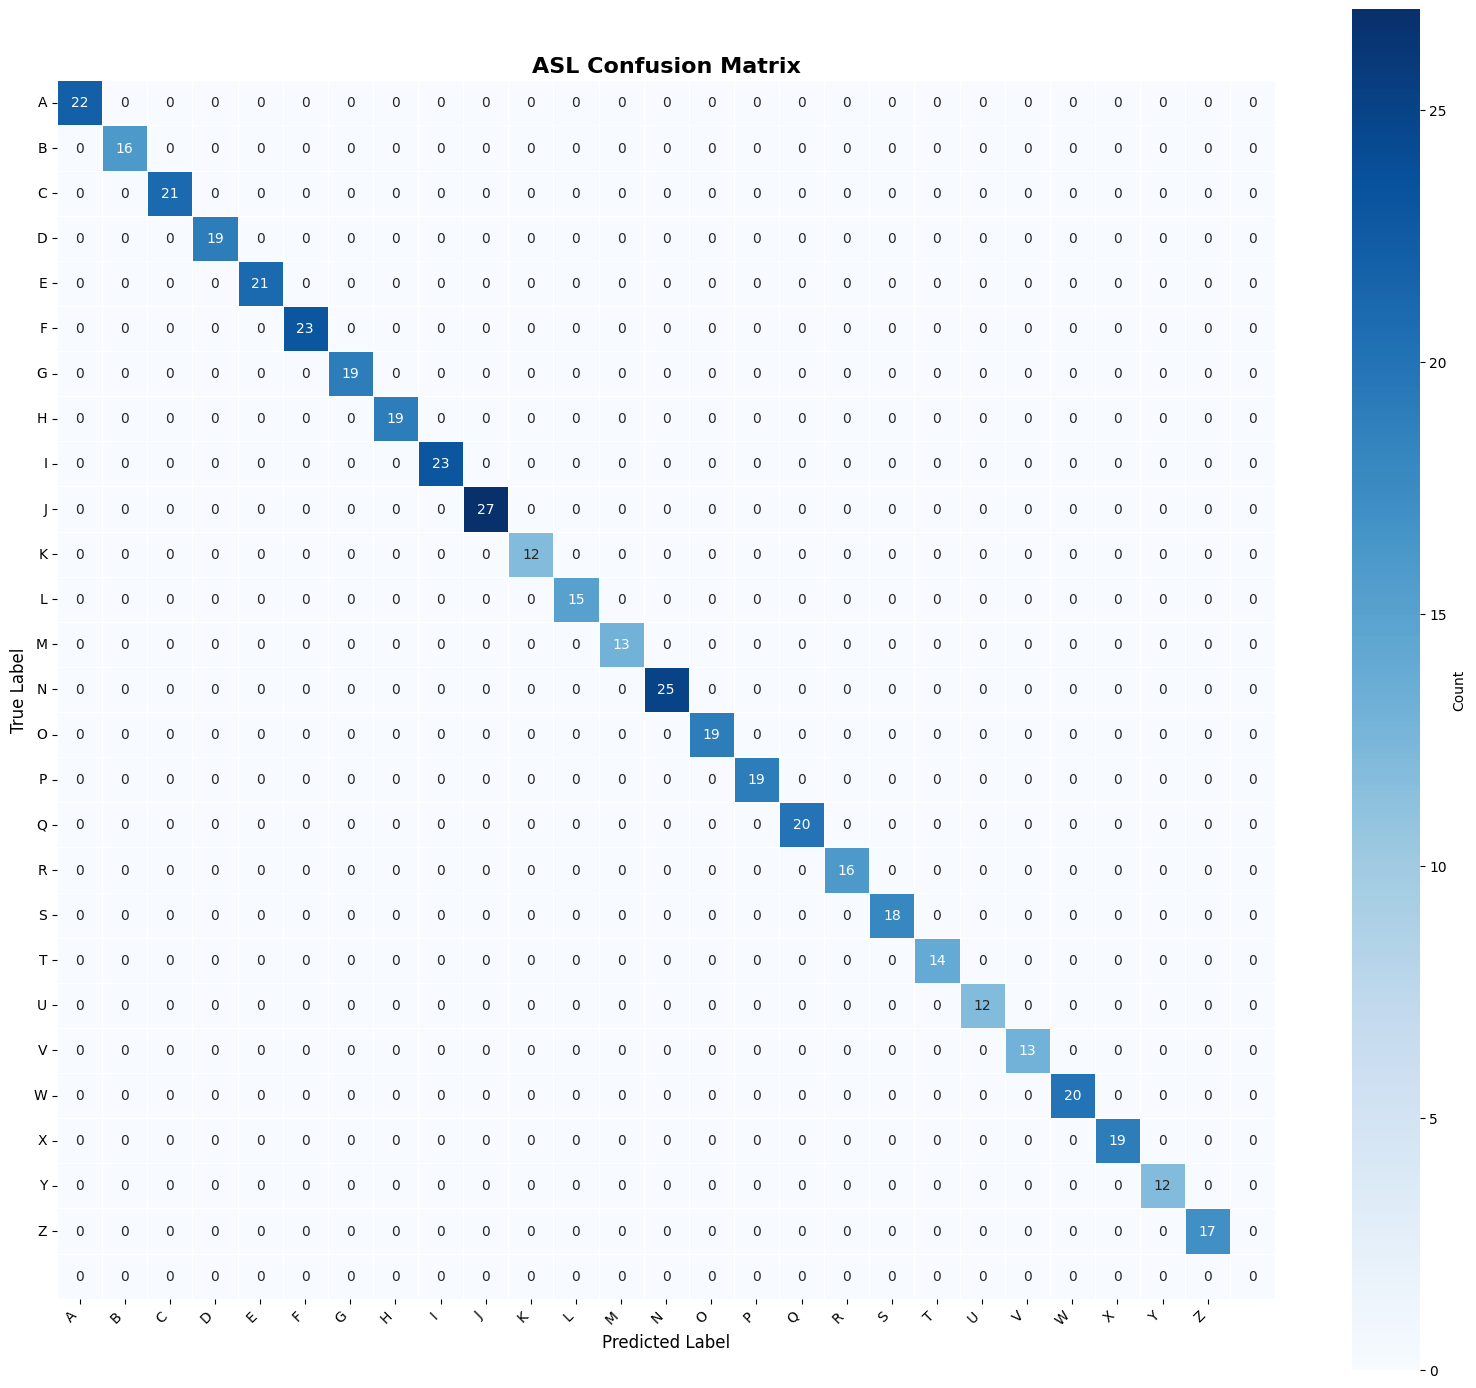

Overall Accuracy from Confusion Matrix: 1.0000
Running inference on test set...

image 1/482 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A11_jpg.rf.bf055dc8a9a5a85bed0cc1f792c56a01.jpg: 640x640 1 A, 2.1ms
image 2/482 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A11_jpg.rf.ff2610c21c7f6d0a793cb58efc3bd96e.jpg: 640x640 1 A, 2.1ms
image 3/482 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A13_jpg.rf.4533aea9a6c32fecadcd1d1963e7dc78.jpg: 640x640 1 A, 2.1ms
image 4/482 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A15_jpg.rf.3654aa7d6bfc342c9ad99f500fd2aaf9.jpg: 640x640 1 A, 2.1ms
image 5/482 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/A16_jpg.rf.4792e25fdaf24e4180ae1a9c1513a39a.jpg: 640x640 1 A, 2.1ms
image 6/482 /home/kjasman/Doc

In [11]:
def plot_custom_confusion_matrix(val_results, model):
    """Plot custom confusion matrix from validation results."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Get confusion matrix and class names
    conf_matrix = np.array(val_results.confusion_matrix.matrix)
    class_names = list(model.names.values())
    
    # Determine if normalized or count data
    is_normalized = conf_matrix.max() <= 1.0
    
    # Create the plot
    plt.figure(figsize=(16, 14))
    
    if is_normalized:
        sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                    square=True, cbar_kws={'label': 'Normalized Frequency'},
                    xticklabels=class_names, yticklabels=class_names,
                    linewidths=0.5)
        title = 'ASL Confusion Matrix (Normalized)'
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues',
                    square=True, cbar_kws={'label': 'Count'},
                    xticklabels=class_names, yticklabels=class_names,
                    linewidths=0.5)
        title = 'ASL Confusion Matrix'
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print accuracy statistics
    if is_normalized:
        accuracy = np.trace(conf_matrix) / len(conf_matrix)
    else:
        total_samples = np.sum(conf_matrix)
        correct_predictions = np.trace(conf_matrix)
        accuracy = correct_predictions / total_samples
        print(f"Overall Accuracy from Confusion Matrix: {accuracy:.4f}")

def validate_model(model, yaml_config_path):
    """Validate the trained model."""
    print("Running validation...")

    # Validate on validation set
    val_results = model.val(
        data=yaml_config_path,
        save=False,          # Don't save prediction images
        save_json=False,     # Don't save JSON results
        save_txt=False,      # Don't save txt results
        plots=True          # Don't save automatic plots
    )

    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")
    
    # Plot custom confusion matrix
    print("\nGenerating custom confusion matrix...")
    plot_custom_confusion_matrix(val_results, model)

    return val_results

def test_model(model, test_images_path):
    """Test the model on test set."""
    print("Running inference on test set...")

    test_results = model.predict(
        source=test_images_path,
        save=True,
        project='yolo_testing',
        name='test_results',
        exist_ok=True,     
        conf=0.25,
        iou=0.45
    )

    return test_results

# Validate the model
validation_results = validate_model(model, yaml_config_path)

# Test on test set
test_images_path = os.path.join(OUTPUT_PATH, 'test', 'images')
test_results = test_model(model, test_images_path)

In [12]:
def plot_training_results():
    """Plot training metrics from the results with column names."""
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    
    results_dir = 'yolo_training/custom_model'

    if os.path.exists(os.path.join(results_dir, 'results.csv')):
        # Load results
        df = pd.read_csv(os.path.join(results_dir, 'results.csv'))
        df.columns = df.columns.str.strip()  # Remove any whitespace
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Box Loss
        axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
        axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='orange')
        axes[0, 0].set_title('Box Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # 2. Classification Loss
        axes[0, 1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', color='blue')
        axes[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', color='orange')
        axes[0, 1].set_title('Classification Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # 3. mAP Metrics
        axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', color='green')
        axes[1, 0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='red')
        axes[1, 0].set_title('mAP Metrics')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('mAP')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # 4. Precision and Recall
        axes[1, 1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', color='purple')
        axes[1, 1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', color='brown')
        axes[1, 1].set_title('Precision & Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()
        
        # Print final metrics
        final_epoch = df.iloc[-1]
        print("\n" + "="*50)
        print("FINAL TRAINING METRICS (Epoch 100)")
        print("="*50)
        print(f"📊 Training Losses:")
        print(f"   Box Loss: {final_epoch['train/box_loss']:.4f}")
        print(f"   Cls Loss: {final_epoch['train/cls_loss']:.4f}")
        print(f"   DFL Loss: {final_epoch['train/dfl_loss']:.4f}")
        print(f"\n📊 Validation Losses:")
        print(f"   Box Loss: {final_epoch['val/box_loss']:.4f}")
        print(f"   Cls Loss: {final_epoch['val/cls_loss']:.4f}")
        print(f"   DFL Loss: {final_epoch['val/dfl_loss']:.4f}")
        print(f"\n🎯 Performance Metrics:")
        print(f"   Precision: {final_epoch['metrics/precision(B)']:.4f}")
        print(f"   Recall: {final_epoch['metrics/recall(B)']:.4f}")
        print(f"   mAP@0.5: {final_epoch['metrics/mAP50(B)']:.4f}")
        print(f"   mAP@0.5:0.95: {final_epoch['metrics/mAP50-95(B)']:.4f}")
        
    else:
        print("Training results not found. Check the training output directory.")

def plot_additional_metrics():
    """Plot additional training metrics like DFL loss and learning rates."""
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    
    results_dir = 'yolo_training/custom_model'

    if os.path.exists(os.path.join(results_dir, 'results.csv')):
        df = pd.read_csv(os.path.join(results_dir, 'results.csv'))
        df.columns = df.columns.str.strip()
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # 1. DFL Loss (Distribution Focal Loss)
        axes[0].plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss', color='blue')
        axes[0].plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss', color='orange')
        axes[0].set_title('Distribution Focal Loss (DFL)')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('DFL Loss')
        axes[0].legend()
        axes[0].grid(True)

        # 2. Learning Rate Schedule
        axes[1].plot(df['epoch'], df['lr/pg0'], label='Learning Rate', color='red')
        axes[1].set_title('Learning Rate Schedule')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Learning Rate')
        axes[1].legend()
        axes[1].grid(True)
        axes[1].set_yscale('log')  # Log scale for better visualization

        plt.tight_layout()
        plt.show()
    else:
        print("Training results not found.")

# Run the corrected plotting functions
plot_training_results()
plot_additional_metrics()



Training results not found. Check the training output directory.
Training results not found.


Testing prediction on: yolo_dataset_split/test/images/E19_jpg.rf.f9ccc5ec73209f6eecaca429420f30c3.jpg

image 1/1 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/E19_jpg.rf.f9ccc5ec73209f6eecaca429420f30c3.jpg: 640x640 1 E, 2.1ms
Speed: 0.9ms preprocess, 2.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


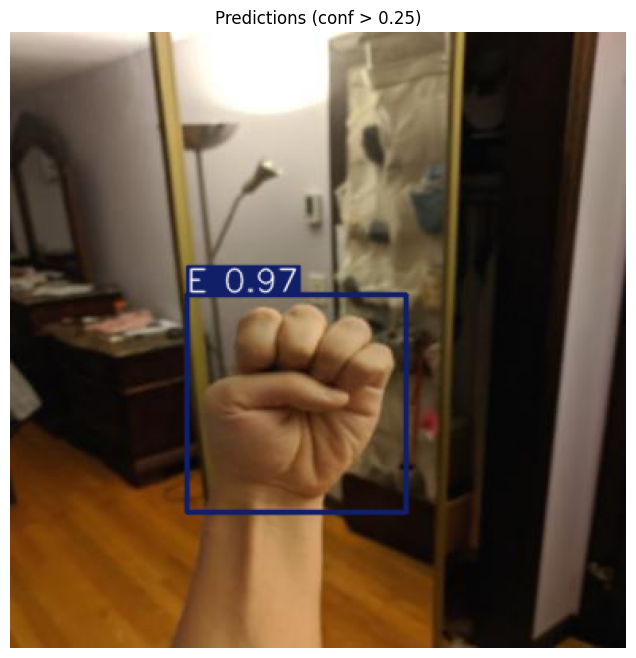

Detection 1: E (confidence: 0.975)


In [13]:
def predict_single_image(model, image_path, conf_threshold=0.25):
    """Make prediction on a single image."""
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        save=False,
        show=False
    )

    # Display results
    for r in results:
        # Plot results
        im_array = r.plot()
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Predictions (conf > {conf_threshold})')
        plt.show()

        # Print detection info
        if len(r.boxes) > 0:
            for i, box in enumerate(r.boxes):
                class_id = int(box.cls[0])
                confidence = float(box.conf[0])
                class_name = CLASS_NAMES[class_id] if class_id < len(CLASS_NAMES) else f"Class_{class_id}"
                print(f"Detection {i+1}: {class_name} (confidence: {confidence:.3f})")
        else:
            print("No detections found")

# Test prediction on a sample image
test_images = os.listdir(os.path.join(OUTPUT_PATH, 'test', 'images'))
if test_images:
    sample_image = os.path.join(OUTPUT_PATH, 'test', 'images', test_images[0])
    print(f"Testing prediction on: {sample_image}")
    predict_single_image(model, sample_image)

In [14]:
print("="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Original dataset: /data/YOLO-Bulk")
print(f"Dataset split completed: {OUTPUT_PATH}")
print(f"Class names loaded from: /data/YOLO-Bulk/data.yaml")
print(f"Model trained for {EPOCHS} epochs")
print(f"Best model saved in: yolo_training/custom_model/weights/")
print(f"Validation results available")
print(f"Test predictions saved in: yolo_testing/test_results/")

print("\nNext steps:")
print("1. Review training metrics and validation results")
print("2. Adjust hyperparameters if needed")
print("3. Test on new images using the trained model")
print("4. Deploy the model for inference")
print("5. Consider data augmentation if performance needs improvement")

# Final model path
final_model_path = "yolo_training/custom_model/weights/best.pt"
print(f"\nTo load the trained model later:")
print(f"model = YOLO('{final_model_path}')")

print(f"\Original dataset unchanged at: /data/YOLO-Bulk")
print(f"Split dataset is available at: {OUTPUT_PATH}")

TRAINING SUMMARY
Original dataset: /data/YOLO-Bulk
Dataset split completed: yolo_dataset_split
Class names loaded from: /data/YOLO-Bulk/data.yaml
Model trained for 100 epochs
Best model saved in: yolo_training/custom_model/weights/
Validation results available
Test predictions saved in: yolo_testing/test_results/

Next steps:
1. Review training metrics and validation results
2. Adjust hyperparameters if needed
3. Test on new images using the trained model
4. Deploy the model for inference
5. Consider data augmentation if performance needs improvement

To load the trained model later:
model = YOLO('yolo_training/custom_model/weights/best.pt')
\Original dataset unchanged at: /data/YOLO-Bulk
Split dataset is available at: yolo_dataset_split


<>:24: SyntaxWarning: invalid escape sequence '\O'
<>:24: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_24752/3851046791.py:24: SyntaxWarning: invalid escape sequence '\O'
  print(f"\Original dataset unchanged at: /data/YOLO-Bulk")
